In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfinv
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# Get the data
data1 = np.loadtxt("HARPS.dat")
data2 = np.loadtxt("HIRES.dat")
data = np.vstack((data1,data2))
print (len(data1),' HARPS points; ',len(data2),' HIRES points')

# Add on jitter (additional noise term)
jitter = 1.2
for i in range(len(data)):
    data[i,2] = np.sqrt( data[i,2]**2 + jitter**2 )

# Initial information from Vogt et al. (2010)
Pb_sol = 5.36841; Pb_del = 0.00026; Kb_sol = 12.45
Pc_sol = 12.9191; Pc_del = 0.0058;  Kc_sol = 3.30
Pd_sol = 66.87;   Pd_del = 0.13;    Kd_sol = 1.91
Pe_sol = 3.14867; Pe_del = 0.00039; Ke_sol = 1.66
Pf_sol = 433.0;   Pf_del = 13.0;    Kf_sol = 1.30
Pg_sol = 36.562;  Pg_del = 0.052;   Kg_sol = 1.29

119  HARPS points;  122  HIRES points


In [2]:
# A full fit is tricky because it's not obvious where to initalize the phases (q) from
# So let's run a pre-fit first, where we only allow the phases to vary
# Trying running this a few times and make sure the same solution is coming out

# Define model M0 fix = 4-planet model using K & P parameters fixed to the Vogt+ reported values
def M0fix(t, qb, qc, qd, qe):
    return Kb_sol*np.sin(2.0*np.pi*t/Pb_sol+qb) \
           + Kc_sol*np.sin(2.0*np.pi*t/Pc_sol+qc) \
           + Kd_sol*np.sin(2.0*np.pi*t/Pd_sol+qd) \
           + Ke_sol*np.sin(2.0*np.pi*t/Pe_sol+qe)

# Define our parameters bounds
param_bounds = ( [-2.0*np.pi, \
                  -2.0*np.pi, \
                  -2.0*np.pi, \
                  -2.0*np.pi],\
                 [2.0*np.pi, \
                  2.0*np.pi, \
                  2.0*np.pi, \
                  2.0*np.pi] )

# Give an intial guess to help the fitting routine
initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi)]

# Get the best fitting parameters
M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

# Get the chi2
chi2 = 0.0
for i in range(len(data)):
    chi2 = chi2 + ( ( data[i,1] - M0fix( data[i,0],\
                                      M0fix_best[0],\
                                      M0fix_best[1],\
                                      M0fix_best[2],\
                                      M0fix_best[3]) ) / data[i,2])**2

# Print output
print (chi2,len(data))

395.79612572406836 241


In [3]:
# OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses
qb_sol = M0fix_best[0]
qc_sol = M0fix_best[1]
qd_sol = M0fix_best[2]
qe_sol = M0fix_best[3]

In [4]:
# Now we're ready to run the full 4-planet fit

# Define model M0 = 4-planet model
def M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe):
    return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
           + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
           + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
           + Ke*np.sin(2.0*np.pi*t/Pe+qe)

# Define our parameters bounds
param_bounds = ( [0.0,  Pb_sol-3.0*Pb_del, -2.0*np.pi, \
                  0.0,  Pc_sol-3.0*Pc_del, -2.0*np.pi, \
                  0.0,  Pd_sol-3.0*Pd_del, -2.0*np.pi, \
                  0.0,  Pe_sol-3.0*Pe_del, -2.0*np.pi],\
                 [20.0, Pb_sol+3.0*Pb_del,  2.0*np.pi, \
                  20.0, Pc_sol+3.0*Pc_del,  2.0*np.pi, \
                  20.0, Pd_sol+3.0*Pd_del,  2.0*np.pi, \
                  20.0, Pe_sol+3.0*Pe_del,  2.0*np.pi] )

# Give an intial guess to help the fitting routine
initial_guess = [ Kb_sol, Pb_sol, qb_sol,\
                  Kc_sol, Pc_sol, qc_sol,\
                  Kd_sol, Pd_sol, qd_sol,\
                  Ke_sol, Pe_sol, qe_sol]

# Get the best fitting parameters
M0_best, M0_cov = curve_fit(M0,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

# Get the chi2
chi2 = 0.0
for i in range(len(data)):
    chi2 = chi2 + ( ( data[i,1] - M0( data[i,0],\
                                      M0_best[0],M0_best[1],M0_best[2],\
                                      M0_best[3],M0_best[4],M0_best[5],\
                                      M0_best[6],M0_best[7],M0_best[8],\
                                      M0_best[9],M0_best[10],M0_best[11]) ) / data[i,2])**2
# Get the loglike
loglike = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2

# Print output
print (chi2,loglike)
print(param_bounds)

390.3946366222394 -567.7796181971883
([0.0, 5.36763, -6.283185307179586, 0.0, 12.9017, -6.283185307179586, 0.0, 66.48, -6.283185307179586, 0.0, 3.1475, -6.283185307179586], [20.0, 5.36919, 6.283185307179586, 20.0, 12.9365, 6.283185307179586, 20.0, 67.26, 6.283185307179586, 20.0, 3.14984, 6.283185307179586])


In [5]:
P_sol = np.array([Pb_sol, Pc_sol, Pd_sol, Pe_sol, Pf_sol, Pg_sol])
P_del = np.array([Pb_del, Pc_del, Pd_del, Pe_del, Pf_del, Pg_del])
K_sol = np.array([Kb_sol, Kc_sol, Kd_sol, Ke_sol, Kf_sol, Kg_sol])

In [6]:
#Want to create callable function for fitting, given params of which model, and which data used
def model(num_pl, data, indices):
    def Mfix(t, *args):
        Mf = 0
        i = 0
        while i < num_pl:
            Mf += K_sol[indices[i]]*np.sin(2.0*np.pi*t/P_sol[indices[i]]+args[i])
            i += 1
        return Mf
    initial_guess_fix = np.array(np.random.uniform(-np.pi,np.pi, size = num_pl))
    param_bounds_fix = [np.tile(-2.0*np.pi, num_pl),np.tile(2.0*np.pi, num_pl)]
    Mfix_best, Mfix_cov = curve_fit(Mfix, data[:,0], data[:,1], sigma=data[:,2], p0=initial_guess_fix, bounds=param_bounds_fix)
    #def M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe):
    def M(t, *args):
        M = 0
        i = 0
        while i < 3*num_pl:
            M += args[i]*np.sin(2.0*np.pi*t/args[i+1]+args[i+2])
            i += 3
        return M
    initial_guess = np.zeros(num_pl*3)
    for i in range (0, num_pl):
        initial_guess[3*i] = K_sol[indices[i]]
        initial_guess[3*i+1] = P_sol[indices[i]]
        initial_guess[3*i+2] = Mfix_best[i]
    param_bounds_low = np.array([0.0,  P_sol[0]-3.0*P_del[0], -2.0*np.pi])
    for i in range(1, num_pl):
        add_on = np.array([0.0,  P_sol[indices[i]]-3.0*P_del[indices[i]], -2.0*np.pi])
        param_bounds_low = np.concatenate((param_bounds_low, add_on))
    param_bounds_high = np.array([20.0,  P_sol[0]+3.0*P_del[0], 2.0*np.pi])
    for i in range(1, num_pl):
        add_on = np.array([20.0,  P_sol[indices[i]]+3.0*P_del[indices[i]], 2.0*np.pi])
        param_bounds_high = np.concatenate((param_bounds_high, add_on)) 
    param_bounds = np.vstack((param_bounds_low, param_bounds_high))
    M_best, M_cov = curve_fit(M, data[:,0], data[:,1], sigma=data[:,2], p0=initial_guess, bounds=param_bounds)
    model = M(data[:,0], *M_best)
    return M_best, model

In [7]:
def chi_2(model, data, errors):
    chi_2 = np.sum(((data - model)/errors)**2)
    return chi_2

In [8]:
def r_chi_2(model, data, errors, params):
    r_chi_2 = chi_2(model, data, errors)/(len(data) - params)
    return r_chi_2

In [9]:
def loglike(model, data, errors):
    loglike = -0.5*len(data)*np.log(2.0*np.pi) - np.sum(np.log(errors)) - 0.5*chi_2(model, data, errors)
    return loglike

In [10]:
def bic(model, data, errors, params):
    bic = -2*loglike(model, data, errors) + params*np.log(len(data))
    return bic

In [11]:
def aic(model, data, errors, params):
    aic = -2*loglike(model, data, errors) + 2*params
    return aic

In [12]:
#Case 0: Model with 4 planets; neither planet f nor planet g

M0_indices = np.array([0,1,2,3])
M0 = model(4, data, M0_indices)[1]
M0_params = len(model(4, data, M0_indices)[0])


M0_chi_2 = chi_2(M0, data[:,1], data[:,2])
M0_r_chi_2 = r_chi_2(M0, data[:,1], data[:,2], M0_params)
M0_loglike = loglike(M0, data[:,1], data[:,2])
M0_bic = bic(M0, data[:,1], data[:,2], M0_params)
M0_aic = aic(M0, data[:,1], data[:,2], M0_params)

In [13]:
#Case 1: Model with planet f only

Mf_indices = np.array([0,1,2,3,4])
Mf = model(5, data, Mf_indices)[1]
Mf_params = len(model(5, data, Mf_indices)[0])


Mf_chi_2 = chi_2(Mf, data[:,1], data[:,2])
Mf_r_chi_2 = r_chi_2(Mf, data[:,1], data[:,2], Mf_params)
Mf_loglike = loglike(Mf, data[:,1], data[:,2])
Mf_bic = bic(Mf, data[:,1], data[:,2], Mf_params)
Mf_aic = aic(Mf, data[:,1], data[:,2], Mf_params)

In [14]:
#Case 2: Model with planet g only
Mg_indices = np.array([0,1,2,3,5])
Mg = model(5, data, Mg_indices)[1]
Mg_params = len(model(5, data, Mg_indices)[0])


Mg_chi_2 = chi_2(Mg, data[:,1], data[:,2])
Mg_r_chi_2 = r_chi_2(Mg, data[:,1], data[:,2], Mg_params)
Mg_loglike = loglike(Mg, data[:,1], data[:,2])
Mg_bic = bic(Mg, data[:,1], data[:,2], Mg_params)
Mg_aic = aic(Mg, data[:,1], data[:,2], Mg_params)

In [15]:
#Case 3: Model with planets f and g
Mfg_indices = np.array([0,1,2,3,4,5])
Mfg = model(6, data, Mfg_indices)[1]
Mfg_params = len(model(6, data, Mfg_indices)[0])


Mfg_chi_2 = chi_2(Mfg, data[:,1], data[:,2])
Mfg_r_chi_2 = r_chi_2(Mfg, data[:,1], data[:,2], Mfg_params)
Mfg_loglike = loglike(Mfg, data[:,1], data[:,2])
Mfg_bic = bic(Mfg, data[:,1], data[:,2], Mfg_params)
Mfg_aic = aic(Mfg, data[:,1], data[:,2], Mfg_params)

In [16]:
# print everything!
print ("Model\t|\t\u03C72\t|\tloglike\t|\tred_\u03C72\t|\tBIC\t|\tAIC")
print("-----------------------------------------------------------------------------------------")
print (f'M0\t|\t{M0_chi_2:.2f}\t|\t{M0_loglike:.2f}\t|\t{M0_r_chi_2:.2f}\t|\t{M0_bic:.2f}\t|\t{M0_aic:.2f}')
print (f'Mf\t|\t{Mf_chi_2:.2f}\t|\t{Mf_loglike:.2f}\t|\t{Mf_r_chi_2:.2f}\t|\t{Mf_bic:.2f}\t|\t{Mf_aic:.2f}')
print (f'Mg\t|\t{Mg_chi_2:.2f}\t|\t{Mg_loglike:.2f}\t|\t{Mg_r_chi_2:.2f}\t|\t{Mg_bic:.2f}\t|\t{Mg_aic:.2f}')
print (f'Mfg\t|\t{Mfg_chi_2:.2f}\t|\t{Mfg_loglike:.2f}\t|\t{Mfg_r_chi_2:.2f}\t|\t{Mfg_bic:.2f}\t|\t{Mfg_aic:.2f}')

Model	|	χ2	|	loglike	|	red_χ2	|	BIC	|	AIC
-----------------------------------------------------------------------------------------
M0	|	390.53	|	-567.85	|	1.71	|	1201.51	|	1159.69
Mf	|	347.08	|	-546.12	|	1.54	|	1174.52	|	1122.25
Mg	|	341.60	|	-543.38	|	1.51	|	1169.04	|	1116.76
Mfg	|	297.63	|	-521.40	|	1.33	|	1141.52	|	1078.79


In [17]:
#go from AIC/BIC to Bayes factor, then converted to p value and percentage
def p(ic1,ic2):
    factor = np.exp(-0.5*(ic2 - ic1))
    percent = 1 - 1/(1+factor)
    p = np.sqrt(2)*erfinv(percent)
    percent_100 = percent*100
    return p, percent_100

In [18]:
#using the functions made, solve for sigmas of each model!
p_0_f_bic = p(M0_bic, Mf_bic)
p_0_f_aic = p(M0_aic, Mf_aic)
p_0_g_bic = p(M0_bic, Mg_bic)
p_0_g_aic = p(M0_aic, Mg_aic)
p_f_fg_bic = p(Mf_bic, Mfg_bic)
p_f_fg_aic = p(Mf_aic, Mfg_aic)
p_g_fg_bic = p(Mg_bic, Mfg_bic)
p_g_fg_aic = p(Mg_aic, Mfg_aic)

In [19]:
# print everything!
print ("Models\t|\tBIC sigmas\t|\tAIC sigmas")
print("--------------------------------------------------------")
print (f'Mf:M0\t|\t{p_0_f_bic[0]:.2f} \t\t|\t{p_0_f_aic[0]:.2f}')
print (f'Mg:M0\t|\t{p_0_g_bic[0]:.2f} \t\t|\t{p_0_g_aic[0]:.2f}')
print (f'Mfg:Mf\t|\t{p_f_fg_bic[0]:.2f} \t\t|\t{p_f_fg_aic[0]:.2f}')
print (f'Mfg:Mg\t|\t{p_g_fg_bic[0]:.2f} \t\t|\t{p_g_fg_aic[0]:.2f}')


Models	|	BIC sigmas	|	AIC sigmas
--------------------------------------------------------
Mf:M0	|	4.83 		|	5.78
Mg:M0	|	5.35 		|	6.23
Mfg:Mf	|	5.40 		|	6.27
Mfg:Mg	|	4.88 		|	5.83


In [20]:
#Tweak model for purposes of leaving p out
def model_leave_out(num_pl, train, validation, indices):
    def Mfix(t, *args):
        Mf = 0
        i = 0
        while i < num_pl:
            Mf += K_sol[indices[i]]*np.sin(2.0*np.pi*t/P_sol[indices[i]]+args[i])
            i += 1
        return Mf
    initial_guess_fix = np.array(np.random.uniform(-np.pi,np.pi, size = num_pl))
    param_bounds_fix = [np.tile(-2.0*np.pi, num_pl),np.tile(2.0*np.pi, num_pl)]
    Mfix_best, Mfix_cov = curve_fit(Mfix, train[:,0], train[:,1], sigma=train[:,2], p0=initial_guess_fix, bounds=param_bounds_fix)
    #def M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe):
    def M(t, *args):
        M = 0
        i = 0
        while i < 3*num_pl:
            M += args[i]*np.sin(2.0*np.pi*t/args[i+1]+args[i+2])
            i += 3
        return M
    initial_guess = np.zeros(num_pl*3)
    for i in range (0, num_pl):
        initial_guess[3*i] = K_sol[indices[i]]
        initial_guess[3*i+1] = P_sol[indices[i]]
        initial_guess[3*i+2] = Mfix_best[i]
    param_bounds_low = np.array([0.0,  P_sol[0]-3.0*P_del[0], -2.0*np.pi])
    for i in range(1, num_pl):
        add_on = np.array([0.0,  P_sol[indices[i]]-3.0*P_del[indices[i]], -2.0*np.pi])
        param_bounds_low = np.concatenate((param_bounds_low, add_on))
    param_bounds_high = np.array([20.0,  P_sol[0]+3.0*P_del[0], 2.0*np.pi])
    for i in range(1, num_pl):
        add_on = np.array([20.0,  P_sol[indices[i]]+3.0*P_del[indices[i]], 2.0*np.pi])
        param_bounds_high = np.concatenate((param_bounds_high, add_on)) 
    param_bounds = np.vstack((param_bounds_low, param_bounds_high))
    M_best, M_cov = curve_fit(M, train[:,0], train[:,1], sigma=train[:,2], p0=initial_guess, bounds=param_bounds)
    model = M(validation[:,0], *M_best)
    return model

In [21]:
#Write leave p out function w/ one parameter: size of p
#have it output chi2 for all four models
def leave_p(p):
    permute = np.random.permutation(data)
    validation = permute[0:p, :]
    train = permute[0:,:]
    M0_v = model_leave_out(4, train, validation, M0_indices)
    Mf_v = model_leave_out(5, train, validation, Mf_indices)
    Mg_v = model_leave_out(5, train, validation, Mg_indices)
    Mfg_v = model_leave_out(6, train, validation, Mfg_indices)
    M0_chi_2 = chi_2(M0_v, validation[:,1], validation[:,2])
    Mf_chi_2 = chi_2(Mf_v, validation[:,1], validation[:,2])
    Mg_chi_2 = chi_2(Mg_v, validation[:,1], validation[:,2])
    Mfg_chi_2 = chi_2(Mfg_v, validation[:,1], validation[:,2])
    return M0_chi_2, Mf_chi_2, Mg_chi_2, Mfg_chi_2

In [22]:
#calculate scores for leave p out
def leave_scores(number, p):
    i = 0
    scores_array = np.zeros(4)
    while i < number:
        imin = np.argmin(leave_p(p))
        scores_i = np.zeros(4)
        scores_i[imin] = 1
        scores_array = np.vstack((scores_array, scores_i))
        i+=1
    scores_total = np.sum(scores_array, axis = 0)
    #scores = scores_total/scores_total[0]
    scores = scores_total

    return scores

In [23]:
scores_41 = leave_scores(500, 41)
scores_percent = scores_41/5

In [24]:
# print everything!
print ("Models\t|\tPercentage of time with Lowest Chi^2")
print("--------------------------------------------------------")
print (f'M0\t|\t{scores_percent[0]:.2f}')
print (f'Mf\t|\t{scores_percent[1]:.2f}')
print (f'Mg\t|\t{scores_percent[2]:.2f}')
print (f'Mfg\t|\t{scores_percent[3]:.2f}')


Models	|	Percentage of time with Lowest Chi^2
--------------------------------------------------------
M0	|	0.80
Mf	|	6.40
Mg	|	8.00
Mfg	|	84.80


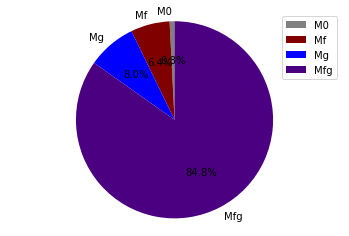

In [25]:
#pie chart of leave p out results
fig1, ax1 = plt.subplots()
labels = 'M0', 'Mf', 'Mg', 'Mfg'
ax1.pie(scores_41, labels=labels, autopct='%1.1f%%', startangle=90, colors = ('gray', 'maroon','blue', 'indigo'))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.savefig('1.pdf')
plt.show()

In [26]:
#create line graph of leave p out results for variable p
scores_t = leave_scores(10, 1)
#larger number of iterations 
for i in range(2,120):
    scores_i = leave_scores(10, i)
    scores_t = np.vstack((scores_t, scores_i))
    

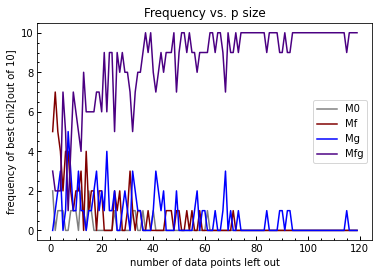

In [27]:
#graph of leave p out results for variable p
t_leave = np.arange(1,120)

fig1, ax = plt.subplots()
def setaxparams(): #axis formatting stuff
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=1, direction='in')
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2, direction='in')
setaxparams()
s = 'M0', 'Mf', 'Mg', 'Mfg'
ax.plot(t_leave, scores_t[:,0], label = 'M0', color = 'gray')
ax.plot(t_leave, scores_t[:,1], label = 'Mf', color = 'maroon')
ax.plot(t_leave, scores_t[:,2], label = 'Mg', color = 'blue')
ax.plot(t_leave, scores_t[:,3], label = 'Mfg', color = 'indigo')
plt.ylabel('frequency of best chi2[out of 10]')
plt.xlabel('number of data points left out')
ax.legend()
ax.set_title('Frequency vs. p size')
plt.savefig('2.pdf')
plt.show()